The goal of this homework is to train a simple model for predicting the duration of a ride - similar to what we did in this module.

https://github.com/DataTalksClub/mlops-zoomcamp/blob/main/cohorts/2024/01-intro/homework.md

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

In [3]:
SEED = 42

# Q1. Downloading the data

Download the data ["Yellow Taxi Trip Records"](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) for January and February 2023. Read the data for January. 

In [4]:
url_yellow_jan_2023 = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet'
url_yellow_feb_2023 = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet'

In [5]:
df_jan = pd.read_parquet(url_yellow_jan_2023)
print(df_jan.shape)
df_jan.head()

(3066766, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [6]:
df_jan['VendorID'].value_counts()

2    2239399
1     827367
Name: VendorID, dtype: int64

How many columns are there?

In [7]:
df_jan.shape[1]

19

__Answer:__ there are 19 columns

# Q2. Computing duration

Now let's compute the duration variable. It should contain the duration of a ride in minutes.

In [8]:
def create_features(df):
    df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
    df['duration'] = df['duration'].apply(lambda x: x.total_seconds() / 60)
    return df

In [9]:
df_jan = create_features(df_jan)

What's the standard deviation of the trips duration in January?

In [10]:
df_jan['duration'].std()

42.594351241920904

__Answer:__ 42.59

# Q3. Dropping outliers

Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

In [11]:
def clear_data(df):
    return df.query('duration >= 1 and duration <= 60').copy()

(3009173, 20)


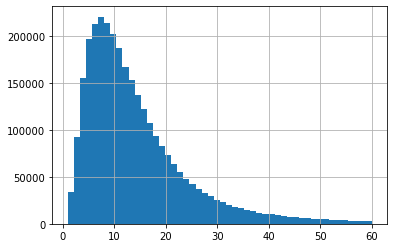

In [12]:
df_jan_f = clear_data(df_jan)
print(df_jan_f.shape)
df_jan_f['duration'].hist(bins=50);

What fraction of the records left after you dropped the outliers?

In [13]:
len(df_jan_f) / len(df_jan)

0.9812202822125979

__Answer__: 98%

# Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

* Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
* Fit a dictionary vectorizer
* Get a feature matrix from it

In [14]:
cat_columns = ['PULocationID', 'DOLocationID']

In [15]:
def fit_encoder(df, cat_columns):
    enc = DictVectorizer(sparse=True)
    return enc.fit(df[cat_columns].astype(str).to_dict(orient='records'))

In [16]:
def encode_data(df, cat_columns, enc):
    return enc.transform(df[cat_columns].astype(str).to_dict(orient='records'))    

In [17]:
enc = fit_encoder(df_jan_f, cat_columns)
X_jan = encode_data(df_jan_f, cat_columns, enc)

What's the dimensionality of this matrix (number of columns)?

In [18]:
X_jan

<3009173x515 sparse matrix of type '<class 'numpy.float64'>'
	with 6018346 stored elements in Compressed Sparse Row format>

__Answer__: 515

# Q5. Training a model

Now let's use the feature matrix from the previous step to train a model.

* Train a plain linear regression model with default parameters
* Calculate the RMSE of the model on the training data

In [19]:
y_jan = df_jan_f['duration']

In [20]:
model = LinearRegression()
model.fit(X_jan, y_jan)
y_pred_jan = model.predict(X_jan)

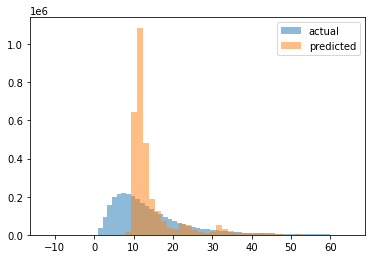

In [21]:
plt.hist(y_jan, bins=50, alpha=0.5, label='actual')
plt.hist(y_pred_jan, bins=50, alpha=0.5, label='predicted')
plt.legend();

What's the RMSE on train?

In [22]:
mean_squared_error(y_jan, y_pred_jan, squared=False)

7.6492610279057605

__Answer__: 7.64

# Q6. Evaluating the model

Now let's apply this model to the validation dataset (February 2023).

In [ ]:
df_feb = pd.read_parquet(url_yellow_feb_2023)
print(df_feb.shape)
df_feb.head()

In [ ]:
df_feb = create_features(df_feb)
df_feb = clear_data(df_feb)
X_feb = encode_data(df_feb, cat_columns, enc)
X_feb

In [ ]:
y_pred_feb = model.predict(X_feb)

What's the RMSE on validation?

In [ ]:
mean_squared_error(df_feb['duration'], y_pred_feb, squared=False)

__Answer__: 7.81